In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import numpy as np
import torch
import collections, re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers import  CuDNNLSTM 
from keras.layers import concatenate
from keras import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
clean_data=pd.read_csv("/content/drive/My Drive/NLP project/final_clean_data.csv",encoding='latin-1') #you need to change the path

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

train_indices, test_indices, y_train, y_test = train_test_split(np.arange(len(clean_data)), clean_data['fraudulent'],
                                                    stratify=clean_data['fraudulent'], 
                                                    test_size=0.3,random_state=0)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(np.array(train_indices).reshape(-1, 1), clean_data.iloc[train_indices]['fraudulent'])
X_resampled=X_resampled.flatten()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
train_indices=X_resampled

In [7]:
clean_data.head()

,job_id,title,company_profile,description,Special_Char,telecommuting,has_company_logo,has_questions,Ambiguous Range,missing_salary,missing_stat,ambiguous_salary,missing,major_benefits,Country_AU,Country_GB,Country_MY,Country_US,State_CA,State_MD,State_NSW,State_NY,State_None,State_TX,employment_type_Contract,employment_type_Full-time,employment_type_None,employment_type_Part-time,required_experience_Associate,required_experience_Entry level,required_experience_Mid-Senior level,required_experience_None,required_education_Bachelor & Assoc,required_education_High School,required_education_Master & Doctorate,required_education_None,required_education_Prof & Cert,industry_accounting,industry_computer networking,industry_consumer services,industry_financial services,industry_hospital health care,industry_information technology services,industry_leisure travel tourism,industry_marketing advertising,industry_none,industry_oil energy,industry_real estate,industry_telecommunications,function_accounting auditing,function_administrative,function_customer service,function_engineering,function_information technology,function_none,function_other,function_sales,fraudulent
0,1,marketing intern,food weve created groundbreaking awardwinning ...,food fastgrowing james beard awardwinning onli...,0,0,1,0,1.0,1,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,customer service cloud video production,seconds worlds cloud video production service ...,organised focused vibrant awesomedo passion cu...,0,0,1,0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,commissioning machinery assistant cma,valor services provides workforce solutions me...,client located houston actively seeking experi...,0,0,1,0,1.0,1,1.0,1.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,4,account executive washington dc,passion improving quality life geography heart...,company esri environmental systems research in...,0,0,1,0,1.0,1,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5,bill review manager,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,0,0,1,1,1.0,1,1.0,1.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
non_text=df1 = clean_data.drop(['title', 'job_id', 'company_profile','description','fraudulent'], axis=1).to_numpy()

In [0]:
clean_data[['company_profile','description']]=clean_data[['company_profile','description']].replace({np.NAN: "Not provided"})
clean_data['company_profile']=clean_data['company_profile'].astype(str)
clean_data['description']=clean_data['description'].astype(str)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=3000, ngram_range=(1,1))
X1 = vectorizer.fit_transform(clean_data["company_profile"]).toarray()
X1_train=X1[train_indices]
X1_test=X1[test_indices]
Y_train=clean_data['fraudulent'][train_indices]
Y_test=clean_data['fraudulent'][test_indices]

X2 = vectorizer.fit_transform(clean_data["description"]).toarray()
X2_train=X2[train_indices]
X2_test=X2[test_indices]
Y_train=clean_data['fraudulent'][train_indices]
Y_test=clean_data['fraudulent'][test_indices]

In [0]:
Y1 = pd.get_dummies(clean_data['fraudulent']).values
Y1_train=Y1[train_indices]
Y1_test=Y1[test_indices]

In [28]:
max_fatures = 30000
model1 = Sequential()
model1.add(Dense(200,activation='softmax',input_shape = (X1.shape[1],)))
model1.add(Dense(50,activation='softmax'))
model1.add(Dense(2,activation='softmax'))

model2 = Sequential()
model2.add(Dense(200,activation='softmax',input_shape = (X2.shape[1],)))
model2.add(Dense(50,activation='softmax'))
model2.add(Dense(2,activation='softmax'))

model3 = Sequential()
model3.add(Dense(80,input_dim=non_text.shape[1],activation='relu'))
model3.add(Dense(40,activation='relu'))
model3.add(Dense(2,activation='sigmoid'))

model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
model_concat = Dense(40, activation='sigmoid')(model_concat)
model_concat = Dense(2, activation='softmax')(model_concat)
model= Model(inputs=[model1.input, model2.input, model3.input], outputs=model_concat)
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history=model.fit([X1_train, X2_train,non_text[train_indices]], Y1_train, epochs = 7, batch_size=30,verbose = 2)

y_pred=model.predict([X1_test, X2_test,non_text[test_indices]],verbose = 2, batch_size = 30)
y_pred1=np.argmax(y_pred,axis=1)
Y1_test1=np.argmax(Y1_test,axis=1)
print(f1_score(Y1_test1, y_pred1))

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_79_input (InputLayer)     (None, 3000)         0                                            
__________________________________________________________________________________________________
dense_82_input (InputLayer)     (None, 3000)         0                                            
__________________________________________________________________________________________________
dense_85_input (InputLayer)     (None, 53)           0                                            
__________________________________________________________________________________________________
dense_79 (Dense)                (None, 200)          600200      dense_79_input[0][0]             
____________________________________________________________________________________________

In [29]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score, precision_score, recall_score
print(f1_score(Y1_test1, y_pred1))
print(confusion_matrix(Y1_test1, y_pred1))
print(accuracy_score(Y1_test1, y_pred1))
print(precision_score(Y1_test1, y_pred1))
print(recall_score(Y1_test1, y_pred1))

0.8166666666666667
[[5080   24]
 [  64  196]]
0.9835943325876212
0.8909090909090909
0.7538461538461538


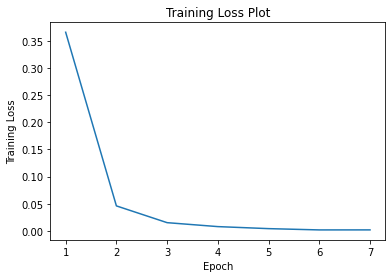

In [30]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.title('Training Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show();

In [0]:
train_indices, test_indices, y_train, y_test = train_test_split(np.arange(len(clean_data)), clean_data['fraudulent'],
                                                    stratify=clean_data['fraudulent'], 
                                                    test_size=0.3,random_state=0)
reduced_train_indices, val_indices, y_train, y_test = train_test_split(train_indices, clean_data.loc[train_indices]['fraudulent'],
                                                    stratify=clean_data.loc[train_indices]['fraudulent'], 
                                                    test_size=0.2,random_state=0)

# **Cross Validation**

In [33]:
train_indices, test_indices, y_train, y_test = train_test_split(np.arange(len(clean_data)), clean_data['fraudulent'],
                                                    stratify=clean_data['fraudulent'], 
                                                    test_size=0.3,random_state=0)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4,random_state=0)
skf.get_n_splits(train_indices, y_train)
stratified_index=[]
for train_index, test_index in skf.split(train_indices, y_train):
  print("TRAIN:", train_index, "TEST:", test_index)
  stratified_index.append({"train":train_index,"test":test_index})
stratified_index

TRAIN: [ 3125  3126  3127 ... 12513 12514 12515] TEST: [   0    1    2 ... 3173 3176 3207]
TRAIN: [    0     1     2 ... 12513 12514 12515] TEST: [3125 3126 3127 ... 6442 6489 6503]
TRAIN: [    0     1     2 ... 12513 12514 12515] TEST: [6244 6245 6246 ... 9958 9959 9962]
TRAIN: [   0    1    2 ... 9958 9959 9962] TEST: [ 9356  9357  9358 ... 12513 12514 12515]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[{'test': array([   0,    1,    2, ..., 3173, 3176, 3207]),
  'train': array([ 3125,  3126,  3127, ..., 12513, 12514, 12515])},
 {'test': array([3125, 3126, 3127, ..., 6442, 6489, 6503]),
  'train': array([    0,     1,     2, ..., 12513, 12514, 12515])},
 {'test': array([6244, 6245, 6246, ..., 9958, 9959, 9962]),
  'train': array([    0,     1,     2, ..., 12513, 12514, 12515])},
 {'test': array([ 9356,  9357,  9358, ..., 12513, 12514, 12515]),
  'train': array([   0,    1,    2, ..., 9958, 9959, 9962])}]

In [34]:
from itertools import product
batch_size = [20, 30, 40]
epochs = [4, 7, 10]
param_grid = list(product(batch_size, epochs))
param_grid

[(20, 4),
 (20, 7),
 (20, 10),
 (30, 4),
 (30, 7),
 (30, 10),
 (40, 4),
 (40, 7),
 (40, 10)]

In [35]:
F_1_cv=[]
embed_dim = 500
lstm_out = 200
from statistics import mean 
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

for i in param_grid:
  f1=[]
  for j in stratified_index:
    X_resampled, y_resampled = ros.fit_resample(np.array(j["train"]).reshape(-1, 1), clean_data.iloc[j["train"]]['fraudulent'])
    X_resampled=X_resampled.flatten()

    model1 = Sequential()
    model1.add(Dense(200,activation='softmax',input_shape = (X1.shape[1],)))
    model1.add(Dense(50,activation='softmax'))
    model1.add(Dense(2,activation='softmax'))

    model2 = Sequential()
    model2.add(Dense(200,activation='softmax',input_shape = (X2.shape[1],)))
    model2.add(Dense(50,activation='softmax'))
    model2.add(Dense(2,activation='softmax'))

    model3 = Sequential()
    model3.add(Dense(80,input_dim=non_text.shape[1],activation='relu'))
    model3.add(Dense(40,activation='relu'))
    model3.add(Dense(2,activation='sigmoid'))

    model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
    model_concat = Dense(40, activation='sigmoid')(model_concat)
    model_concat = Dense(2, activation='softmax')(model_concat)
    model= Model(inputs=[model1.input, model2.input, model3.input], outputs=model_concat)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    model.fit([X1[X_resampled], X2[X_resampled],non_text[X_resampled]], Y1[X_resampled], epochs = i[1], batch_size=i[0],verbose = 2)

    y_pred=model.predict([X1[j["test"]], X2[j["test"]],non_text[j["test"]]],verbose = 2, batch_size = i[0])
    y_pred1=np.argmax(y_pred,axis=1)
    Y1_test1=np.argmax(Y1[j["test"]],axis=1)
    print(f1_score(Y1_test1, y_pred1))
    f1.append(f1_score(Y1_test1, y_pred1))
  F_1_cv.append([i,sum(f1)/4])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 16s - loss: 0.3700 - accuracy: 0.8606
Epoch 2/4
 - 16s - loss: 0.0465 - accuracy: 0.9875
Epoch 3/4
 - 16s - loss: 0.0111 - accuracy: 0.9984
Epoch 4/4
 - 16s - loss: 0.0048 - accuracy: 0.9993
0.6829268292682926


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.3707 - accuracy: 0.8709
Epoch 2/4
 - 19s - loss: 0.1240 - accuracy: 0.9600
Epoch 3/4
 - 17s - loss: 0.0147 - accuracy: 0.9972
Epoch 4/4
 - 17s - loss: 0.0039 - accuracy: 0.9998
0.5494505494505494


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.4043 - accuracy: 0.8431
Epoch 2/4
 - 17s - loss: 0.0401 - accuracy: 0.9910
Epoch 3/4
 - 17s - loss: 0.0078 - accuracy: 0.9987
Epoch 4/4
 - 17s - loss: 0.0036 - accuracy: 0.9992
0.5901639344262294


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.3995 - accuracy: 0.8546
Epoch 2/4
 - 17s - loss: 0.0520 - accuracy: 0.9866
Epoch 3/4
 - 17s - loss: 0.0122 - accuracy: 0.9983
Epoch 4/4
 - 17s - loss: 0.0057 - accuracy: 0.9993
0.7101449275362319


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 18s - loss: 0.3845 - accuracy: 0.8554
Epoch 2/7
 - 17s - loss: 0.0387 - accuracy: 0.9911
Epoch 3/7
 - 17s - loss: 0.0093 - accuracy: 0.9988
Epoch 4/7
 - 17s - loss: 0.0037 - accuracy: 0.9997
Epoch 5/7
 - 17s - loss: 0.0023 - accuracy: 0.9997
Epoch 6/7
 - 17s - loss: 9.6469e-04 - accuracy: 1.0000
Epoch 7/7
 - 17s - loss: 0.0016 - accuracy: 0.9997
0.6832298136645962


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 18s - loss: 0.4175 - accuracy: 0.8568
Epoch 2/7
 - 17s - loss: 0.0453 - accuracy: 0.9870
Epoch 3/7
 - 17s - loss: 0.0079 - accuracy: 0.9992
Epoch 4/7
 - 17s - loss: 0.0033 - accuracy: 0.9997
Epoch 5/7
 - 17s - loss: 0.0015 - accuracy: 1.0000
Epoch 6/7
 - 17s - loss: 5.3389e-04 - accuracy: 1.0000
Epoch 7/7
 - 17s - loss: 2.7894e-04 - accuracy: 1.0000
0.45378151260504207


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 18s - loss: 0.4112 - accuracy: 0.8412
Epoch 2/7
 - 18s - loss: 0.0613 - accuracy: 0.9823
Epoch 3/7
 - 18s - loss: 0.0083 - accuracy: 0.9993
Epoch 4/7
 - 18s - loss: 0.0032 - accuracy: 0.9997
Epoch 5/7
 - 19s - loss: 0.0029 - accuracy: 0.9994
Epoch 6/7
 - 18s - loss: 8.1906e-04 - accuracy: 1.0000
Epoch 7/7
 - 18s - loss: 4.7480e-04 - accuracy: 1.0000
0.6024096385542169


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 19s - loss: 0.4023 - accuracy: 0.8510
Epoch 2/7
 - 19s - loss: 0.0653 - accuracy: 0.9800
Epoch 3/7
 - 18s - loss: 0.0161 - accuracy: 0.9968
Epoch 4/7
 - 18s - loss: 0.0082 - accuracy: 0.9982
Epoch 5/7
 - 18s - loss: 0.0081 - accuracy: 0.9981
Epoch 6/7
 - 19s - loss: 0.0048 - accuracy: 0.9985
Epoch 7/7
 - 18s - loss: 0.0022 - accuracy: 0.9995
0.6762589928057554


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 20s - loss: 0.3738 - accuracy: 0.8680
Epoch 2/10
 - 18s - loss: 0.0556 - accuracy: 0.9830
Epoch 3/10
 - 18s - loss: 0.0141 - accuracy: 0.9970
Epoch 4/10
 - 18s - loss: 0.0067 - accuracy: 0.9985
Epoch 5/10
 - 18s - loss: 0.0039 - accuracy: 0.9991
Epoch 6/10
 - 18s - loss: 0.0023 - accuracy: 0.9994
Epoch 7/10
 - 17s - loss: 0.0028 - accuracy: 0.9991
Epoch 8/10
 - 18s - loss: 0.0018 - accuracy: 0.9996
Epoch 9/10
 - 17s - loss: 0.0011 - accuracy: 0.9996
Epoch 10/10
 - 18s - loss: 0.0011 - accuracy: 0.9998
0.5930232558139535


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.3502 - accuracy: 0.8806
Epoch 2/10
 - 18s - loss: 0.0311 - accuracy: 0.9915
Epoch 3/10
 - 18s - loss: 0.0058 - accuracy: 0.9997
Epoch 4/10
 - 18s - loss: 0.0028 - accuracy: 0.9998
Epoch 5/10
 - 18s - loss: 0.0014 - accuracy: 0.9999
Epoch 6/10
 - 18s - loss: 7.9594e-04 - accuracy: 1.0000
Epoch 7/10
 - 18s - loss: 4.7974e-04 - accuracy: 1.0000
Epoch 8/10
 - 18s - loss: 2.8167e-04 - accuracy: 1.0000
Epoch 9/10
 - 18s - loss: 1.7407e-04 - accuracy: 1.0000
Epoch 10/10
 - 18s - loss: 1.0328e-04 - accuracy: 1.0000
0.5079365079365079


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.4044 - accuracy: 0.8345
Epoch 2/10
 - 18s - loss: 0.0392 - accuracy: 0.9913
Epoch 3/10
 - 18s - loss: 0.0085 - accuracy: 0.9993
Epoch 4/10
 - 18s - loss: 0.0036 - accuracy: 0.9998
Epoch 5/10
 - 18s - loss: 0.0018 - accuracy: 0.9999
Epoch 6/10
 - 18s - loss: 9.2108e-04 - accuracy: 1.0000
Epoch 7/10
 - 20s - loss: 5.0623e-04 - accuracy: 1.0000
Epoch 8/10
 - 18s - loss: 3.0234e-04 - accuracy: 1.0000
Epoch 9/10
 - 18s - loss: 1.7114e-04 - accuracy: 1.0000
Epoch 10/10
 - 18s - loss: 1.0392e-04 - accuracy: 1.0000
0.626984126984127


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.3998 - accuracy: 0.8553
Epoch 2/10
 - 18s - loss: 0.0563 - accuracy: 0.9836
Epoch 3/10
 - 18s - loss: 0.0117 - accuracy: 0.9982
Epoch 4/10
 - 18s - loss: 0.0061 - accuracy: 0.9988
Epoch 5/10
 - 18s - loss: 0.0032 - accuracy: 0.9995
Epoch 6/10
 - 18s - loss: 0.0022 - accuracy: 0.9996
Epoch 7/10
 - 18s - loss: 0.0011 - accuracy: 0.9998
Epoch 8/10
 - 18s - loss: 6.3357e-04 - accuracy: 0.9999
Epoch 9/10
 - 18s - loss: 3.2491e-04 - accuracy: 1.0000
Epoch 10/10
 - 18s - loss: 0.0017 - accuracy: 0.9996
0.7368421052631579


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 14s - loss: 0.4370 - accuracy: 0.8459
Epoch 2/4
 - 13s - loss: 0.1316 - accuracy: 0.9550
Epoch 3/4
 - 13s - loss: 0.0222 - accuracy: 0.9962
Epoch 4/4
 - 13s - loss: 0.0086 - accuracy: 0.9988
0.7052023121387283


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 14s - loss: 0.4023 - accuracy: 0.8583
Epoch 2/4
 - 13s - loss: 0.0605 - accuracy: 0.9791
Epoch 3/4
 - 13s - loss: 0.0089 - accuracy: 0.9994
Epoch 4/4
 - 13s - loss: 0.0034 - accuracy: 0.9999
0.5375494071146245


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 14s - loss: 0.4577 - accuracy: 0.8301
Epoch 2/4
 - 14s - loss: 0.0965 - accuracy: 0.9685
Epoch 3/4
 - 14s - loss: 0.0146 - accuracy: 0.9989
Epoch 4/4
 - 13s - loss: 0.0063 - accuracy: 0.9994
0.5668016194331984


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 14s - loss: 0.5083 - accuracy: 0.8142
Epoch 2/4
 - 13s - loss: 0.1324 - accuracy: 0.9553
Epoch 3/4
 - 13s - loss: 0.0211 - accuracy: 0.9961
Epoch 4/4
 - 13s - loss: 0.0096 - accuracy: 0.9981
0.6944444444444444


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 14s - loss: 0.4453 - accuracy: 0.8343
Epoch 2/7
 - 13s - loss: 0.1013 - accuracy: 0.9666
Epoch 3/7
 - 13s - loss: 0.0171 - accuracy: 0.9981
Epoch 4/7
 - 13s - loss: 0.0076 - accuracy: 0.9994
Epoch 5/7
 - 13s - loss: 0.0042 - accuracy: 0.9998
Epoch 6/7
 - 13s - loss: 0.0028 - accuracy: 0.9997
Epoch 7/7
 - 13s - loss: 0.0017 - accuracy: 0.9999
0.670886075949367


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 14s - loss: 0.4194 - accuracy: 0.8647
Epoch 2/7
 - 13s - loss: 0.0816 - accuracy: 0.9727
Epoch 3/7
 - 13s - loss: 0.0128 - accuracy: 0.9991
Epoch 4/7
 - 14s - loss: 0.0050 - accuracy: 0.9997
Epoch 5/7
 - 13s - loss: 0.0027 - accuracy: 0.9999
Epoch 6/7
 - 13s - loss: 0.0020 - accuracy: 0.9998
Epoch 7/7
 - 13s - loss: 0.0010 - accuracy: 1.0000
0.525096525096525


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 14s - loss: 0.4476 - accuracy: 0.8223
Epoch 2/7
 - 13s - loss: 0.0751 - accuracy: 0.9759
Epoch 3/7
 - 13s - loss: 0.0118 - accuracy: 0.9989
Epoch 4/7
 - 13s - loss: 0.0043 - accuracy: 0.9997
Epoch 5/7
 - 13s - loss: 0.0023 - accuracy: 0.9998
Epoch 6/7
 - 13s - loss: 0.0014 - accuracy: 1.0000
Epoch 7/7
 - 13s - loss: 8.6860e-04 - accuracy: 1.0000
0.5423728813559322


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 13s - loss: 0.4476 - accuracy: 0.8407
Epoch 2/7
 - 12s - loss: 0.1754 - accuracy: 0.9378
Epoch 3/7
 - 12s - loss: 0.0809 - accuracy: 0.9743
Epoch 4/7
 - 12s - loss: 0.0242 - accuracy: 0.9949
Epoch 5/7
 - 12s - loss: 0.0081 - accuracy: 0.9993
Epoch 6/7
 - 12s - loss: 0.0044 - accuracy: 0.9996
Epoch 7/7
 - 12s - loss: 0.0029 - accuracy: 0.9995
0.7662337662337663


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 14s - loss: 0.4845 - accuracy: 0.8286
Epoch 2/10
 - 13s - loss: 0.1539 - accuracy: 0.9465
Epoch 3/10
 - 13s - loss: 0.0244 - accuracy: 0.9962
Epoch 4/10
 - 13s - loss: 0.0086 - accuracy: 0.9991
Epoch 5/10
 - 13s - loss: 0.0047 - accuracy: 0.9997
Epoch 6/10
 - 13s - loss: 0.0027 - accuracy: 0.9999
Epoch 7/10
 - 13s - loss: 0.0019 - accuracy: 0.9998
Epoch 8/10
 - 13s - loss: 0.0011 - accuracy: 0.9999
Epoch 9/10
 - 13s - loss: 6.5197e-04 - accuracy: 1.0000
Epoch 10/10
 - 13s - loss: 4.3780e-04 - accuracy: 1.0000
0.7305389221556886


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 15s - loss: 0.4094 - accuracy: 0.8555
Epoch 2/10
 - 14s - loss: 0.0585 - accuracy: 0.9811
Epoch 3/10
 - 14s - loss: 0.0090 - accuracy: 0.9995
Epoch 4/10
 - 14s - loss: 0.0031 - accuracy: 0.9999
Epoch 5/10
 - 14s - loss: 0.0015 - accuracy: 1.0000
Epoch 6/10
 - 14s - loss: 9.1431e-04 - accuracy: 1.0000
Epoch 7/10
 - 14s - loss: 5.9833e-04 - accuracy: 1.0000
Epoch 8/10
 - 14s - loss: 4.1582e-04 - accuracy: 1.0000
Epoch 9/10
 - 14s - loss: 4.5922e-04 - accuracy: 0.9999
Epoch 10/10
 - 14s - loss: 2.2951e-04 - accuracy: 1.0000
0.4444444444444445


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 15s - loss: 0.4613 - accuracy: 0.8273
Epoch 2/10
 - 14s - loss: 0.0775 - accuracy: 0.9764
Epoch 3/10
 - 14s - loss: 0.0133 - accuracy: 0.9987
Epoch 4/10
 - 14s - loss: 0.0054 - accuracy: 0.9996
Epoch 5/10
 - 14s - loss: 0.0032 - accuracy: 0.9995
Epoch 6/10
 - 14s - loss: 0.0023 - accuracy: 0.9998
Epoch 7/10
 - 14s - loss: 0.0014 - accuracy: 0.9999
Epoch 8/10
 - 14s - loss: 0.0011 - accuracy: 0.9999
Epoch 9/10
 - 14s - loss: 7.0478e-04 - accuracy: 0.9999
Epoch 10/10
 - 14s - loss: 9.2401e-04 - accuracy: 0.9999
0.7306273062730627


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 15s - loss: 0.4702 - accuracy: 0.8262
Epoch 2/10
 - 14s - loss: 0.1360 - accuracy: 0.9557
Epoch 3/10
 - 14s - loss: 0.0205 - accuracy: 0.9976
Epoch 4/10
 - 15s - loss: 0.0074 - accuracy: 0.9994
Epoch 5/10
 - 14s - loss: 0.0042 - accuracy: 0.9997
Epoch 6/10
 - 14s - loss: 0.0031 - accuracy: 0.9996
Epoch 7/10
 - 14s - loss: 0.0014 - accuracy: 0.9999
Epoch 8/10
 - 14s - loss: 8.3277e-04 - accuracy: 0.9999
Epoch 9/10
 - 14s - loss: 5.5352e-04 - accuracy: 0.9999
Epoch 10/10
 - 14s - loss: 3.9290e-04 - accuracy: 0.9999
0.7007299270072993


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 13s - loss: 0.4719 - accuracy: 0.8310
Epoch 2/4
 - 12s - loss: 0.1544 - accuracy: 0.9466
Epoch 3/4
 - 11s - loss: 0.0281 - accuracy: 0.9948
Epoch 4/4
 - 11s - loss: 0.0104 - accuracy: 0.9991
0.6127167630057804


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 13s - loss: 0.4642 - accuracy: 0.8422
Epoch 2/4
 - 12s - loss: 0.1480 - accuracy: 0.9490
Epoch 3/4
 - 12s - loss: 0.0308 - accuracy: 0.9937
Epoch 4/4
 - 12s - loss: 0.0099 - accuracy: 0.9991
0.4780876494023904


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 13s - loss: 0.4970 - accuracy: 0.8092
Epoch 2/4
 - 12s - loss: 0.1757 - accuracy: 0.9354
Epoch 3/4
 - 12s - loss: 0.0402 - accuracy: 0.9925
Epoch 4/4
 - 12s - loss: 0.0194 - accuracy: 0.9954
0.5704225352112676


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 13s - loss: 0.5021 - accuracy: 0.8186
Epoch 2/4
 - 12s - loss: 0.2664 - accuracy: 0.9121
Epoch 3/4
 - 12s - loss: 0.1050 - accuracy: 0.9643
Epoch 4/4
 - 12s - loss: 0.0214 - accuracy: 0.9972
0.7692307692307692


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 13s - loss: 0.5034 - accuracy: 0.8216
Epoch 2/7
 - 12s - loss: 0.1710 - accuracy: 0.9400
Epoch 3/7
 - 12s - loss: 0.0391 - accuracy: 0.9890
Epoch 4/7
 - 14s - loss: 0.0149 - accuracy: 0.9977
Epoch 5/7
 - 12s - loss: 0.0069 - accuracy: 0.9992
Epoch 6/7
 - 12s - loss: 0.0040 - accuracy: 0.9995
Epoch 7/7
 - 12s - loss: 0.0026 - accuracy: 0.9996
0.6582278481012658


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 14s - loss: 0.5008 - accuracy: 0.8175
Epoch 2/7
 - 12s - loss: 0.1265 - accuracy: 0.9566
Epoch 3/7
 - 12s - loss: 0.0213 - accuracy: 0.9977
Epoch 4/7
 - 12s - loss: 0.0069 - accuracy: 0.9998
Epoch 5/7
 - 12s - loss: 0.0035 - accuracy: 0.9999
Epoch 6/7
 - 12s - loss: 0.0019 - accuracy: 0.9999
Epoch 7/7
 - 12s - loss: 0.0011 - accuracy: 0.9999
0.504


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 14s - loss: 0.4761 - accuracy: 0.8280
Epoch 2/7
 - 12s - loss: 0.2034 - accuracy: 0.9311
Epoch 3/7
 - 12s - loss: 0.0353 - accuracy: 0.9941
Epoch 4/7
 - 12s - loss: 0.0109 - accuracy: 0.9988
Epoch 5/7
 - 12s - loss: 0.0060 - accuracy: 0.9990
Epoch 6/7
 - 12s - loss: 0.0042 - accuracy: 0.9993
Epoch 7/7
 - 12s - loss: 0.0026 - accuracy: 0.9997
0.5905511811023622


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 13s - loss: 0.5071 - accuracy: 0.8073
Epoch 2/7
 - 12s - loss: 0.2564 - accuracy: 0.9161
Epoch 3/7
 - 12s - loss: 0.0906 - accuracy: 0.9710
Epoch 4/7
 - 12s - loss: 0.0249 - accuracy: 0.9956
Epoch 5/7
 - 12s - loss: 0.0129 - accuracy: 0.9973
Epoch 6/7
 - 12s - loss: 0.0078 - accuracy: 0.9986
Epoch 7/7
 - 12s - loss: 0.0062 - accuracy: 0.9987
0.5806451612903225


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 14s - loss: 0.4880 - accuracy: 0.8272
Epoch 2/10
 - 12s - loss: 0.1739 - accuracy: 0.9410
Epoch 3/10
 - 12s - loss: 0.0385 - accuracy: 0.9877
Epoch 4/10
 - 12s - loss: 0.0151 - accuracy: 0.9963
Epoch 5/10
 - 12s - loss: 0.0080 - accuracy: 0.9982
Epoch 6/10
 - 12s - loss: 0.0049 - accuracy: 0.9994
Epoch 7/10
 - 12s - loss: 0.0033 - accuracy: 0.9996
Epoch 8/10
 - 12s - loss: 0.0021 - accuracy: 0.9999
Epoch 9/10
 - 12s - loss: 0.0018 - accuracy: 0.9999
Epoch 10/10
 - 12s - loss: 9.9551e-04 - accuracy: 1.0000
0.6415094339622641


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 14s - loss: 0.5412 - accuracy: 0.8121
Epoch 2/10
 - 12s - loss: 0.1596 - accuracy: 0.9483
Epoch 3/10
 - 13s - loss: 0.0263 - accuracy: 0.9966
Epoch 4/10
 - 13s - loss: 0.0085 - accuracy: 0.9994
Epoch 5/10
 - 12s - loss: 0.0043 - accuracy: 0.9998
Epoch 6/10
 - 12s - loss: 0.0027 - accuracy: 0.9999
Epoch 7/10
 - 12s - loss: 0.0025 - accuracy: 0.9998
Epoch 8/10
 - 12s - loss: 0.0021 - accuracy: 0.9997
Epoch 9/10
 - 14s - loss: 0.0014 - accuracy: 0.9998
Epoch 10/10
 - 12s - loss: 7.2287e-04 - accuracy: 1.0000
0.5363984674329502


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 14s - loss: 0.5033 - accuracy: 0.8074
Epoch 2/10
 - 13s - loss: 0.1572 - accuracy: 0.9451
Epoch 3/10
 - 13s - loss: 0.0272 - accuracy: 0.9965
Epoch 4/10
 - 13s - loss: 0.0100 - accuracy: 0.9987
Epoch 5/10
 - 13s - loss: 0.0065 - accuracy: 0.9989
Epoch 6/10
 - 13s - loss: 0.0043 - accuracy: 0.9991
Epoch 7/10
 - 13s - loss: 0.0023 - accuracy: 0.9994
Epoch 8/10
 - 13s - loss: 0.0024 - accuracy: 0.9995
Epoch 9/10
 - 13s - loss: 0.0014 - accuracy: 0.9994
Epoch 10/10
 - 12s - loss: 8.0291e-04 - accuracy: 1.0000
0.49789029535864976


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 14s - loss: 0.5104 - accuracy: 0.8192
Epoch 2/10
 - 13s - loss: 0.1848 - accuracy: 0.9348
Epoch 3/10
 - 12s - loss: 0.0326 - accuracy: 0.9953
Epoch 4/10
 - 12s - loss: 0.0123 - accuracy: 0.9985
Epoch 5/10
 - 13s - loss: 0.0061 - accuracy: 0.9996
Epoch 6/10
 - 12s - loss: 0.0042 - accuracy: 0.9996
Epoch 7/10
 - 12s - loss: 0.0029 - accuracy: 0.9997
Epoch 8/10
 - 12s - loss: 0.0021 - accuracy: 0.9998
Epoch 9/10
 - 13s - loss: 0.0023 - accuracy: 0.9997
Epoch 10/10
 - 12s - loss: 0.0014 - accuracy: 0.9999
0.7194244604316546


In [36]:
F_1_cv

[[(20, 4), 0.6331715601703258],
 [(20, 7), 0.6039199894074025],
 [(20, 10), 0.6161964989994366],
 [(30, 4), 0.6259994457827489],
 [(30, 7), 0.6261473121588976],
 [(30, 10), 0.6515851499701237],
 [(40, 4), 0.6076144292125519],
 [(40, 7), 0.5833560476234876],
 [(40, 10), 0.5988056642963797]]

In [0]:
from keras import backend as K
import tensorflow as tf
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [42]:
F_1_cv=[]
embed_dim = 500
lstm_out = 200
from statistics import mean 
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

for i in param_grid:
  f1=[]
  for j in stratified_index:
    X_resampled, y_resampled = ros.fit_resample(np.array(j["train"]).reshape(-1, 1), clean_data.iloc[j["train"]]['fraudulent'])
    X_resampled=X_resampled.flatten()

    model1 = Sequential()
    model1.add(Dense(200,activation='softmax',input_shape = (X1.shape[1],)))
    model1.add(Dense(50,activation='softmax'))
    model1.add(Dense(2,activation='softmax'))

    model2 = Sequential()
    model2.add(Dense(200,activation='softmax',input_shape = (X2.shape[1],)))
    model2.add(Dense(50,activation='softmax'))
    model2.add(Dense(2,activation='softmax'))

    model3 = Sequential()
    model3.add(Dense(80,input_dim=non_text.shape[1],activation='relu'))
    model3.add(Dense(40,activation='relu'))
    model3.add(Dense(2,activation='sigmoid'))

    model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
    model_concat = Dense(40, activation='sigmoid')(model_concat)
    model_concat = Dense(2, activation='softmax')(model_concat)
    model= Model(inputs=[model1.input, model2.input, model3.input], outputs=model_concat)
    model.compile(loss = f1_loss, optimizer='adam',metrics = ['accuracy'])
    model.fit([X1[X_resampled], X2[X_resampled],non_text[X_resampled]], Y1[X_resampled], epochs = i[1], batch_size=i[0],verbose = 2)

    y_pred=model.predict([X1[j["test"]], X2[j["test"]],non_text[j["test"]]],verbose = 2, batch_size = i[0])
    y_pred1=np.argmax(y_pred,axis=1)
    Y1_test1=np.argmax(Y1[j["test"]],axis=1)
    print(f1_score(Y1_test1, y_pred1))
    f1.append(f1_score(Y1_test1, y_pred1))
  F_1_cv.append([i,sum(f1)/4])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 23s - loss: 0.2316 - accuracy: 0.8480
Epoch 2/4
 - 21s - loss: 0.0287 - accuracy: 0.9802
Epoch 3/4
 - 21s - loss: 0.0058 - accuracy: 0.9964
Epoch 4/4
 - 21s - loss: 0.0037 - accuracy: 0.9972
0.6301369863013699


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 23s - loss: 0.2284 - accuracy: 0.8608
Epoch 2/4
 - 22s - loss: 0.0795 - accuracy: 0.9280
Epoch 3/4
 - 22s - loss: 0.0620 - accuracy: 0.9422
Epoch 4/4
 - 22s - loss: 0.0294 - accuracy: 0.9739
0.4912280701754387


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 23s - loss: 0.2438 - accuracy: 0.8361
Epoch 2/4
 - 21s - loss: 0.0729 - accuracy: 0.9359
Epoch 3/4
 - 22s - loss: 0.0109 - accuracy: 0.9915
Epoch 4/4
 - 22s - loss: 0.0057 - accuracy: 0.9952
0.46086956521739136


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 24s - loss: 0.2484 - accuracy: 0.8400
Epoch 2/4
 - 22s - loss: 0.1116 - accuracy: 0.8962
Epoch 3/4
 - 22s - loss: 0.0825 - accuracy: 0.9238
Epoch 4/4
 - 22s - loss: 0.0615 - accuracy: 0.9440
0.6363636363636364


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 25s - loss: 0.2290 - accuracy: 0.8579
Epoch 2/7
 - 23s - loss: 0.0612 - accuracy: 0.9467
Epoch 3/7
 - 23s - loss: 0.0100 - accuracy: 0.9935
Epoch 4/7
 - 23s - loss: 0.0058 - accuracy: 0.9957
Epoch 5/7
 - 23s - loss: 0.0049 - accuracy: 0.9960
Epoch 6/7
 - 23s - loss: 0.0047 - accuracy: 0.9960
Epoch 7/7
 - 23s - loss: 0.0043 - accuracy: 0.9962
0.6380368098159509


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 25s - loss: 0.2166 - accuracy: 0.8774
Epoch 2/7
 - 24s - loss: 0.0129 - accuracy: 0.9939
Epoch 3/7
 - 23s - loss: 0.0035 - accuracy: 0.9981
Epoch 4/7
 - 23s - loss: 0.0026 - accuracy: 0.9983
Epoch 5/7
 - 23s - loss: 0.0023 - accuracy: 0.9983
Epoch 6/7
 - 23s - loss: 0.0020 - accuracy: 0.9983
Epoch 7/7
 - 23s - loss: 0.0019 - accuracy: 0.9983
0.4979591836734694


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 25s - loss: 0.2270 - accuracy: 0.8495
Epoch 2/7
 - 24s - loss: 0.0581 - accuracy: 0.9505
Epoch 3/7
 - 24s - loss: 0.0170 - accuracy: 0.9852
Epoch 4/7
 - 24s - loss: 0.0097 - accuracy: 0.9918
Epoch 5/7
 - 24s - loss: 0.0086 - accuracy: 0.9924
Epoch 6/7
 - 23s - loss: 0.0083 - accuracy: 0.9925
Epoch 7/7
 - 23s - loss: 0.0082 - accuracy: 0.9925
0.5106382978723404


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 25s - loss: 0.2371 - accuracy: 0.8519
Epoch 2/7
 - 23s - loss: 0.0401 - accuracy: 0.9692
Epoch 3/7
 - 23s - loss: 0.0077 - accuracy: 0.9953
Epoch 4/7
 - 23s - loss: 0.0044 - accuracy: 0.9969
Epoch 5/7
 - 23s - loss: 0.0036 - accuracy: 0.9971
Epoch 6/7
 - 23s - loss: 0.0031 - accuracy: 0.9974
Epoch 7/7
 - 23s - loss: 0.0045 - accuracy: 0.9960
0.732824427480916


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 26s - loss: 0.2220 - accuracy: 0.8576
Epoch 2/10
 - 24s - loss: 0.0496 - accuracy: 0.9568
Epoch 3/10
 - 25s - loss: 0.0092 - accuracy: 0.9943
Epoch 4/10
 - 24s - loss: 0.0055 - accuracy: 0.9960
Epoch 5/10
 - 24s - loss: 0.0041 - accuracy: 0.9967
Epoch 6/10
 - 24s - loss: 0.0029 - accuracy: 0.9977
Epoch 7/10
 - 24s - loss: 0.0026 - accuracy: 0.9977
Epoch 8/10
 - 24s - loss: 0.0026 - accuracy: 0.9977
Epoch 9/10
 - 24s - loss: 0.0025 - accuracy: 0.9977
Epoch 10/10
 - 24s - loss: 0.0025 - accuracy: 0.9977
0.6363636363636364


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 25s - loss: 0.2224 - accuracy: 0.8571
Epoch 2/10
 - 23s - loss: 0.0211 - accuracy: 0.9856
Epoch 3/10
 - 23s - loss: 0.0043 - accuracy: 0.9978
Epoch 4/10
 - 23s - loss: 0.0026 - accuracy: 0.9983
Epoch 5/10
 - 23s - loss: 0.0022 - accuracy: 0.9983
Epoch 6/10
 - 23s - loss: 0.0020 - accuracy: 0.9983
Epoch 7/10
 - 23s - loss: 0.0019 - accuracy: 0.9983
Epoch 8/10
 - 23s - loss: 0.0018 - accuracy: 0.9983
Epoch 9/10
 - 23s - loss: 0.0018 - accuracy: 0.9983
Epoch 10/10
 - 23s - loss: 0.0018 - accuracy: 0.9983
0.46090534979423875


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 25s - loss: 0.2469 - accuracy: 0.8442
Epoch 2/10
 - 23s - loss: 0.0658 - accuracy: 0.9424
Epoch 3/10
 - 23s - loss: 0.0072 - accuracy: 0.9961
Epoch 4/10
 - 23s - loss: 0.0037 - accuracy: 0.9978
Epoch 5/10
 - 23s - loss: 0.0028 - accuracy: 0.9980
Epoch 6/10
 - 23s - loss: 0.0021 - accuracy: 0.9983
Epoch 7/10
 - 24s - loss: 0.0019 - accuracy: 0.9984
Epoch 8/10
 - 23s - loss: 0.0018 - accuracy: 0.9985
Epoch 9/10
 - 24s - loss: 0.0017 - accuracy: 0.9985
Epoch 10/10
 - 24s - loss: 0.0017 - accuracy: 0.9985
0.5833333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 25s - loss: 0.2301 - accuracy: 0.8564
Epoch 2/10
 - 23s - loss: 0.0386 - accuracy: 0.9687
Epoch 3/10
 - 23s - loss: 0.0086 - accuracy: 0.9937
Epoch 4/10
 - 23s - loss: 0.0061 - accuracy: 0.9949
Epoch 5/10
 - 23s - loss: 0.0055 - accuracy: 0.9951
Epoch 6/10
 - 23s - loss: 0.0040 - accuracy: 0.9965
Epoch 7/10
 - 23s - loss: 0.0033 - accuracy: 0.9971
Epoch 8/10
 - 23s - loss: 0.0032 - accuracy: 0.9971
Epoch 9/10
 - 23s - loss: 0.0031 - accuracy: 0.9971
Epoch 10/10
 - 23s - loss: 0.0031 - accuracy: 0.9971
0.7175572519083969


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.2876 - accuracy: 0.8218
Epoch 2/4
 - 16s - loss: 0.0753 - accuracy: 0.9327
Epoch 3/4
 - 16s - loss: 0.0157 - accuracy: 0.9892
Epoch 4/4
 - 16s - loss: 0.0069 - accuracy: 0.9951
0.6496815286624203


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.2534 - accuracy: 0.8524
Epoch 2/4
 - 16s - loss: 0.0444 - accuracy: 0.9641
Epoch 3/4
 - 16s - loss: 0.0071 - accuracy: 0.9965
Epoch 4/4
 - 16s - loss: 0.0036 - accuracy: 0.9978
0.49411764705882355


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.2693 - accuracy: 0.8327
Epoch 2/4
 - 16s - loss: 0.1130 - accuracy: 0.8977
Epoch 3/4
 - 16s - loss: 0.0770 - accuracy: 0.9286
Epoch 4/4
 - 16s - loss: 0.0114 - accuracy: 0.9929
0.580392156862745


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 18s - loss: 0.2805 - accuracy: 0.8377
Epoch 2/4
 - 16s - loss: 0.0943 - accuracy: 0.9162
Epoch 3/4
 - 16s - loss: 0.0376 - accuracy: 0.9674
Epoch 4/4
 - 15s - loss: 0.0206 - accuracy: 0.9812
0.556390977443609


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 18s - loss: 0.2723 - accuracy: 0.8389
Epoch 2/7
 - 16s - loss: 0.0743 - accuracy: 0.9349
Epoch 3/7
 - 16s - loss: 0.0137 - accuracy: 0.9927
Epoch 4/7
 - 16s - loss: 0.0054 - accuracy: 0.9974
Epoch 5/7
 - 16s - loss: 0.0031 - accuracy: 0.9982
Epoch 6/7
 - 16s - loss: 0.0025 - accuracy: 0.9983
Epoch 7/7
 - 16s - loss: 0.0020 - accuracy: 0.9986
0.6666666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 18s - loss: 0.2682 - accuracy: 0.8429
Epoch 2/7
 - 16s - loss: 0.0908 - accuracy: 0.9202
Epoch 3/7
 - 16s - loss: 0.0758 - accuracy: 0.9291
Epoch 4/7
 - 16s - loss: 0.0645 - accuracy: 0.9390
Epoch 5/7
 - 16s - loss: 0.0537 - accuracy: 0.9500
Epoch 6/7
 - 16s - loss: 0.0213 - accuracy: 0.9815
Epoch 7/7
 - 16s - loss: 0.0083 - accuracy: 0.9931
0.4377358490566038


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 18s - loss: 0.2894 - accuracy: 0.8189
Epoch 2/7
 - 16s - loss: 0.0806 - accuracy: 0.9305
Epoch 3/7
 - 16s - loss: 0.0144 - accuracy: 0.9905
Epoch 4/7
 - 16s - loss: 0.0087 - accuracy: 0.9930
Epoch 5/7
 - 16s - loss: 0.0072 - accuracy: 0.9938
Epoch 6/7
 - 16s - loss: 0.0066 - accuracy: 0.9940
Epoch 7/7
 - 16s - loss: 0.0062 - accuracy: 0.9942
0.540983606557377


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 19s - loss: 0.2836 - accuracy: 0.8273
Epoch 2/7
 - 16s - loss: 0.1036 - accuracy: 0.9037
Epoch 3/7
 - 16s - loss: 0.0212 - accuracy: 0.9874
Epoch 4/7
 - 16s - loss: 0.0056 - accuracy: 0.9969
Epoch 5/7
 - 16s - loss: 0.0030 - accuracy: 0.9980
Epoch 6/7
 - 16s - loss: 0.0024 - accuracy: 0.9983
Epoch 7/7
 - 17s - loss: 0.0017 - accuracy: 0.9987
0.7194244604316546


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.2620 - accuracy: 0.8481
Epoch 2/10
 - 16s - loss: 0.1019 - accuracy: 0.9085
Epoch 3/10
 - 16s - loss: 0.0867 - accuracy: 0.9181
Epoch 4/10
 - 16s - loss: 0.0642 - accuracy: 0.9392
Epoch 5/10
 - 16s - loss: 0.0224 - accuracy: 0.9808
Epoch 6/10
 - 16s - loss: 0.0148 - accuracy: 0.9868
Epoch 7/10
 - 16s - loss: 0.0111 - accuracy: 0.9901
Epoch 8/10
 - 17s - loss: 0.0103 - accuracy: 0.9904
Epoch 9/10
 - 17s - loss: 0.0101 - accuracy: 0.9904
Epoch 10/10
 - 17s - loss: 0.0099 - accuracy: 0.9905
0.5617977528089887


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.2581 - accuracy: 0.8578
Epoch 2/10
 - 17s - loss: 0.0769 - accuracy: 0.9326
Epoch 3/10
 - 17s - loss: 0.0368 - accuracy: 0.9679
Epoch 4/10
 - 17s - loss: 0.0062 - accuracy: 0.9965
Epoch 5/10
 - 17s - loss: 0.0034 - accuracy: 0.9976
Epoch 6/10
 - 17s - loss: 0.0027 - accuracy: 0.9981
Epoch 7/10
 - 17s - loss: 0.0025 - accuracy: 0.9981
Epoch 8/10
 - 17s - loss: 0.0023 - accuracy: 0.9981
Epoch 9/10
 - 17s - loss: 0.0022 - accuracy: 0.9981
Epoch 10/10
 - 17s - loss: 0.0025 - accuracy: 0.9979
0.44015444015444016


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.2760 - accuracy: 0.8345
Epoch 2/10
 - 17s - loss: 0.1032 - accuracy: 0.9052
Epoch 3/10
 - 17s - loss: 0.0354 - accuracy: 0.9705
Epoch 4/10
 - 17s - loss: 0.0132 - accuracy: 0.9896
Epoch 5/10
 - 17s - loss: 0.0107 - accuracy: 0.9909
Epoch 6/10
 - 17s - loss: 0.0099 - accuracy: 0.9912
Epoch 7/10
 - 17s - loss: 0.0095 - accuracy: 0.9912
Epoch 8/10
 - 17s - loss: 0.0094 - accuracy: 0.9912
Epoch 9/10
 - 17s - loss: 0.0094 - accuracy: 0.9911
Epoch 10/10
 - 17s - loss: 0.0090 - accuracy: 0.9914
0.47154471544715443


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 19s - loss: 0.2707 - accuracy: 0.8393
Epoch 2/10
 - 17s - loss: 0.1016 - accuracy: 0.9074
Epoch 3/10
 - 17s - loss: 0.0234 - accuracy: 0.9836
Epoch 4/10
 - 17s - loss: 0.0078 - accuracy: 0.9940
Epoch 5/10
 - 17s - loss: 0.0050 - accuracy: 0.9959
Epoch 6/10
 - 17s - loss: 0.0044 - accuracy: 0.9962
Epoch 7/10
 - 17s - loss: 0.0043 - accuracy: 0.9960
Epoch 8/10
 - 17s - loss: 0.0046 - accuracy: 0.9958
Epoch 9/10
 - 17s - loss: 0.0040 - accuracy: 0.9963
Epoch 10/10
 - 17s - loss: 0.0045 - accuracy: 0.9958
0.6535947712418301


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 16s - loss: 0.3045 - accuracy: 0.8428
Epoch 2/4
 - 14s - loss: 0.0817 - accuracy: 0.9282
Epoch 3/4
 - 13s - loss: 0.0177 - accuracy: 0.9904
Epoch 4/4
 - 13s - loss: 0.0050 - accuracy: 0.9978
0.6582278481012658


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 16s - loss: 0.2875 - accuracy: 0.8483
Epoch 2/4
 - 13s - loss: 0.0864 - accuracy: 0.9270
Epoch 3/4
 - 13s - loss: 0.0602 - accuracy: 0.9452
Epoch 4/4
 - 13s - loss: 0.0480 - accuracy: 0.9561
0.5552238805970149


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 16s - loss: 0.3170 - accuracy: 0.8276
Epoch 2/4
 - 14s - loss: 0.1185 - accuracy: 0.8968
Epoch 3/4
 - 14s - loss: 0.0511 - accuracy: 0.9587
Epoch 4/4
 - 14s - loss: 0.0083 - accuracy: 0.9957
0.7665505226480837


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
 - 16s - loss: 0.3274 - accuracy: 0.8043
Epoch 2/4
 - 13s - loss: 0.1233 - accuracy: 0.8948
Epoch 3/4
 - 13s - loss: 0.1032 - accuracy: 0.9035
Epoch 4/4
 - 13s - loss: 0.0978 - accuracy: 0.9067
0.2901234567901234


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 16s - loss: 0.2990 - accuracy: 0.8309
Epoch 2/7
 - 13s - loss: 0.0968 - accuracy: 0.9179
Epoch 3/7
 - 14s - loss: 0.0415 - accuracy: 0.9659
Epoch 4/7
 - 14s - loss: 0.0106 - accuracy: 0.9933
Epoch 5/7
 - 14s - loss: 0.0058 - accuracy: 0.9964
Epoch 6/7
 - 13s - loss: 0.0035 - accuracy: 0.9978
Epoch 7/7
 - 13s - loss: 0.0028 - accuracy: 0.9981
0.6627218934911242


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 16s - loss: 0.2984 - accuracy: 0.8450
Epoch 2/7
 - 13s - loss: 0.0634 - accuracy: 0.9487
Epoch 3/7
 - 14s - loss: 0.0134 - accuracy: 0.9925
Epoch 4/7
 - 13s - loss: 0.0045 - accuracy: 0.9974
Epoch 5/7
 - 14s - loss: 0.0030 - accuracy: 0.9980
Epoch 6/7
 - 13s - loss: 0.0026 - accuracy: 0.9980
Epoch 7/7
 - 14s - loss: 0.0023 - accuracy: 0.9980
0.4308943089430894


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 16s - loss: 0.3100 - accuracy: 0.8247
Epoch 2/7
 - 14s - loss: 0.1006 - accuracy: 0.9086
Epoch 3/7
 - 14s - loss: 0.0193 - accuracy: 0.9865
Epoch 4/7
 - 14s - loss: 0.0072 - accuracy: 0.9949
Epoch 5/7
 - 14s - loss: 0.0071 - accuracy: 0.9939
Epoch 6/7
 - 14s - loss: 0.0065 - accuracy: 0.9941
Epoch 7/7
 - 14s - loss: 0.0061 - accuracy: 0.9943
0.47457627118644063


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/7
 - 16s - loss: 0.3319 - accuracy: 0.8103
Epoch 2/7
 - 14s - loss: 0.1111 - accuracy: 0.9043
Epoch 3/7
 - 14s - loss: 0.0341 - accuracy: 0.9748
Epoch 4/7
 - 14s - loss: 0.0137 - accuracy: 0.9891
Epoch 5/7
 - 14s - loss: 0.0096 - accuracy: 0.9915
Epoch 6/7
 - 14s - loss: 0.0085 - accuracy: 0.9921
Epoch 7/7
 - 14s - loss: 0.0064 - accuracy: 0.9944
0.7432432432432433


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 16s - loss: 0.3019 - accuracy: 0.8403
Epoch 2/10
 - 14s - loss: 0.0988 - accuracy: 0.9156
Epoch 3/10
 - 14s - loss: 0.0482 - accuracy: 0.9579
Epoch 4/10
 - 14s - loss: 0.0160 - accuracy: 0.9878
Epoch 5/10
 - 14s - loss: 0.0098 - accuracy: 0.9923
Epoch 6/10
 - 14s - loss: 0.0081 - accuracy: 0.9930
Epoch 7/10
 - 14s - loss: 0.0075 - accuracy: 0.9932
Epoch 8/10
 - 14s - loss: 0.0073 - accuracy: 0.9932
Epoch 9/10
 - 14s - loss: 0.0072 - accuracy: 0.9932
Epoch 10/10
 - 14s - loss: 0.0072 - accuracy: 0.9932
0.5508982035928145


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 17s - loss: 0.2961 - accuracy: 0.8520
Epoch 2/10
 - 15s - loss: 0.0667 - accuracy: 0.9438
Epoch 3/10
 - 15s - loss: 0.0105 - accuracy: 0.9953
Epoch 4/10
 - 15s - loss: 0.0040 - accuracy: 0.9977
Epoch 5/10
 - 15s - loss: 0.0028 - accuracy: 0.9980
Epoch 6/10
 - 15s - loss: 0.0033 - accuracy: 0.9974
Epoch 7/10
 - 15s - loss: 0.0025 - accuracy: 0.9982
Epoch 8/10
 - 15s - loss: 0.0023 - accuracy: 0.9980
Epoch 9/10
 - 15s - loss: 0.0025 - accuracy: 0.9979
Epoch 10/10
 - 15s - loss: 0.0021 - accuracy: 0.9982
0.45344129554655876


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 18s - loss: 0.2972 - accuracy: 0.8262
Epoch 2/10
 - 16s - loss: 0.1101 - accuracy: 0.9044
Epoch 3/10
 - 16s - loss: 0.0594 - accuracy: 0.9467
Epoch 4/10
 - 16s - loss: 0.0101 - accuracy: 0.9930
Epoch 5/10
 - 16s - loss: 0.0082 - accuracy: 0.9931
Epoch 6/10
 - 16s - loss: 0.0072 - accuracy: 0.9936
Epoch 7/10
 - 16s - loss: 0.0066 - accuracy: 0.9940
Epoch 8/10
 - 16s - loss: 0.0046 - accuracy: 0.9958
Epoch 9/10
 - 15s - loss: 0.0030 - accuracy: 0.9972
Epoch 10/10
 - 16s - loss: 0.0025 - accuracy: 0.9981
0.5232067510548524


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
 - 18s - loss: 0.3104 - accuracy: 0.8244
Epoch 2/10
 - 15s - loss: 0.0861 - accuracy: 0.9279
Epoch 3/10
 - 15s - loss: 0.0181 - accuracy: 0.9893
Epoch 4/10
 - 15s - loss: 0.0112 - accuracy: 0.9916
Epoch 5/10
 - 15s - loss: 0.0093 - accuracy: 0.9923
Epoch 6/10
 - 15s - loss: 0.0085 - accuracy: 0.9924
Epoch 7/10
 - 15s - loss: 0.0081 - accuracy: 0.9926
Epoch 8/10
 - 15s - loss: 0.0078 - accuracy: 0.9927
Epoch 9/10
 - 15s - loss: 0.0075 - accuracy: 0.9928
Epoch 10/10
 - 15s - loss: 0.0075 - accuracy: 0.9928
0.6250000000000001


In [43]:
F_1_cv

[[(20, 4), 0.554649564514459],
 [(20, 7), 0.5948646797106691],
 [(20, 10), 0.5995398928499013],
 [(30, 4), 0.5701455775068994],
 [(30, 7), 0.5912026456780755],
 [(30, 10), 0.5317729199131034],
 [(40, 4), 0.567531427034122],
 [(40, 7), 0.5778589292159744],
 [(40, 10), 0.5381365625485565]]

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

train_indices, test_indices, y_train, y_test = train_test_split(np.arange(len(clean_data)), clean_data['fraudulent'],
                                                    stratify=clean_data['fraudulent'], 
                                                    test_size=0.3,random_state=0)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(np.array(train_indices).reshape(-1, 1), clean_data.iloc[train_indices]['fraudulent'])
train_indices=X_resampled.flatten()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
max_fatures = 30000
model1 = Sequential()
model1.add(Dense(200,activation='softmax',input_shape = (X1.shape[1],)))
model1.add(Dense(50,activation='softmax'))
model1.add(Dense(2,activation='softmax'))

model2 = Sequential()
model2.add(Dense(200,activation='softmax',input_shape = (X2.shape[1],)))
model2.add(Dense(50,activation='softmax'))
model2.add(Dense(2,activation='softmax'))

model3 = Sequential()
model3.add(Dense(80,input_dim=non_text.shape[1],activation='relu'))
model3.add(Dense(40,activation='relu'))
model3.add(Dense(2,activation='sigmoid'))

model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
model_concat = Dense(40, activation='sigmoid')(model_concat)
model_concat = Dense(2, activation='softmax')(model_concat)
model= Model(inputs=[model1.input, model2.input, model3.input], outputs=model_concat)
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history=model.fit([X1_train, X2_train,non_text[train_indices]], Y1_train, epochs = 10, batch_size=30,verbose = 2)

y_pred=model.predict([X1_test, X2_test,non_text[test_indices]],verbose = 2, batch_size = 30)
y_pred1=np.argmax(y_pred,axis=1)
Y1_test1=np.argmax(Y1_test,axis=1)
print(f1_score(Y1_test1, y_pred1))

Model: "model_90"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_970_input (InputLayer)    (None, 3000)         0                                            
__________________________________________________________________________________________________
dense_973_input (InputLayer)    (None, 3000)         0                                            
__________________________________________________________________________________________________
dense_976_input (InputLayer)    (None, 53)           0                                            
__________________________________________________________________________________________________
dense_970 (Dense)               (None, 200)          600200      dense_970_input[0][0]            
___________________________________________________________________________________________

In [50]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score, precision_score, recall_score
print(f1_score(Y1_test1, y_pred1))
print(confusion_matrix(Y1_test1, y_pred1))
print(accuracy_score(Y1_test1, y_pred1))
print(precision_score(Y1_test1, y_pred1))
print(recall_score(Y1_test1, y_pred1))

0.7870967741935484
[[5082   22]
 [  77  183]]
0.9815436241610739
0.8926829268292683
0.7038461538461539


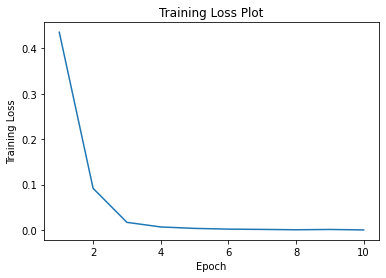

In [51]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.title('Training Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show();